In [24]:
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
base_path = "../data/raw/IDC_regular_ps50_idx5"
print("path exists?", os.path.exists(base_path))

path exists? True


In [3]:
patient_ids = os.listdir(base_path)
print("Number of patients: ", len(patient_ids))
print("First 5 patients: ", patient_ids[:5])

Number of patients:  280
First 5 patients:  ['9036', '10268', '10257', '8913', '13613']


In [4]:
sample_patient = patient_ids[0]

patient_path = os.path.join(base_path, sample_patient)

benign_path = os.path.join(patient_path, "0")
malignant_path = os.path.join(patient_path, "1")

print("Benign images: ", len(os.listdir(benign_path)))
print("Malignant images: ", len(os.listdir(malignant_path)))

Benign images:  1276
Malignant images:  30


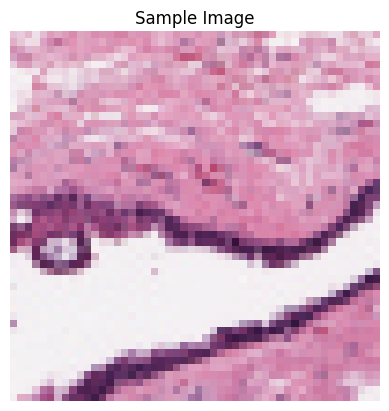

Image size:  (50, 50)
Image mode:  RGB


In [5]:
sample_image_path = os.path.join(benign_path, os.listdir(benign_path)[0])

image = Image.open(sample_image_path)

plt.imshow(image)
plt.title("Sample Image")
plt.axis("off")
plt.show()

print("Image size: ", image.size)
print("Image mode: ", image.mode)

In [6]:
patient_ids = [
    p for p in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, p))
]
print("Total patients: ", len(patient_ids))

Total patients:  279


In [7]:
# splitting patients (not images)
train_patients, test_patients = train_test_split(
    patient_ids,
    test_size = 0.2,
    random_state = 42
)

print("Train patients: ", len(train_patients))
print("Test patients: ", len(test_patients))

Train patients:  223
Test patients:  56


In [8]:
# to verify there is no leakage:
print("Overlap: ", set(train_patients).intersection(set(test_patients)))

Overlap:  set()


In [9]:
import os
import shutil

RAW_DIR = "../data/raw"
PROCESSED_DIR = "../data/processed"

for patient in train_patients:
    patient_path = os.path.join(RAW_DIR, patient)

    for label in ["0", "1"]:
        label_path = os.path.join(patient_path, label)

        if os.path.exists(label_path):
            for img in os.listdir(label_path):
                src = os.path.join(label_path, img)
                dst = os.path.join(PROCESSED_DIR, "train", label, img)
                shutil.copy(src, dst)

for patient in test_patients:
    patient_path = os.path.join(RAW_DIR, patient)

    for label in ["0", "1"]:
        label_path = os.path.join(patient_path, label)

        if os.path.exists(label_path):
            for img in os.listdir(label_path):
                src = os.path.join(label_path, img)
                dst = os.path.join(PROCESSED_DIR, "test", label, img)
                shutil.copy(src, dst)

In [10]:
train_images = []
train_labels = []

for patient in train_patients:
    patient_path = os.path.join(base_path, patient)

    for label in ["0", "1"]:
        label_path = os.path.join(patient_path, label)

        if os.path.exists(label_path):
            for img in os.listdir(label_path):
                img_path = os.path.join(label_path, img)
                train_images.append(img_path)
                train_labels.append(int(label))

In [11]:
test_images = []
test_labels = []

for patient in test_patients:
    patient_path = os.path.join(base_path, patient)

    for label in ["0", "1"]:
        label_path = os.path.join(patient_path, label)

        if os.path.exists(label_path):
            for img in os.listdir(label_path):
                img_path = os.path.join(label_path, img)
                test_images.append(img_path)
                test_labels.append(int(label))

In [12]:
# checking class balance:
print("Train class distribution: ")
print(pd.Series(train_labels).value_counts())

print("\nTest class distribution: ")
print(pd.Series(test_labels).value_counts())

Train class distribution: 
0    155946
1     62302
Name: count, dtype: int64

Test class distribution: 
0    42792
1    16484
Name: count, dtype: int64


In [13]:
IMG_SIZE = 128
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/processed/train",
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/processed/test",
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 218248 files belonging to 2 classes.


2026-02-22 23:25:53.119836: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2026-02-22 23:25:53.119886: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-22 23:25:53.119889: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-22 23:25:53.119928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-22 23:25:53.119959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 59276 files belonging to 2 classes.


In [14]:
class_names = train_ds.class_names
print("classes: ", class_names)

classes:  ['0', '1']


In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache("tf_cache").shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache("tf_test_cache").prefetch(buffer_size=AUTOTUNE)

In [17]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (128, 128, 3),
    include_top = False,
    weights = "imagenet"
)

base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape = (128, 128, 3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

/Users/bhuwanthapa/Documents/Breast_cancer_prediction/venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [19]:
class_weight = {0: 1.0, 1: 2.5}

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="breast_cancer_mobilenetv2.keras",
    monitor="val_accuracy",
    save_best_only=True
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25,
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/25


2026-02-22 23:25:57.195735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5822/6821 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.8000 - loss: 0.6303

2026-02-22 23:29:41.920893: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


6820/6821 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8017 - loss: 0.6263

2026-02-22 23:31:12.853862: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


6821/6821 ━━━━━━━━━━━━━━━━━━━━ 317s 45ms/step - accuracy: 0.8125 - loss: 0.6018 - val_accuracy: 0.8116 - val_loss: 0.4269
Epoch 2/25
6821/6821 ━━━━━━━━━━━━━━━━━━━━ 349s 51ms/step - accuracy: 0.8187 - loss: 0.5820 - val_accuracy: 0.8236 - val_loss: 0.4054
Epoch 3/25
6821/6821 ━━━━━━━━━━━━━━━━━━━━ 290s 42ms/step - accuracy: 0.8194 - loss: 0.5796 - val_accuracy: 0.8459 - val_loss: 0.3620
Epoch 4/25


2026-02-22 23:47:21.590917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 109 of 1000


   1/6821 ━━━━━━━━━━━━━━━━━━━━ 630:50:58 333s/step - accuracy: 0.7500 - loss: 0.5908

2026-02-22 23:47:25.037698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


6821/6821 ━━━━━━━━━━━━━━━━━━━━ 676s 50ms/step - accuracy: 0.8202 - loss: 0.5792 - val_accuracy: 0.8163 - val_loss: 0.4171
Epoch 5/25
6821/6821 ━━━━━━━━━━━━━━━━━━━━ 287s 42ms/step - accuracy: 0.8194 - loss: 0.5785 - val_accuracy: 0.8100 - val_loss: 0.4325
Epoch 6/25
6821/6821 ━━━━━━━━━━━━━━━━━━━━ 295s 43ms/step - accuracy: 0.8202 - loss: 0.5789 - val_accuracy: 0.8219 - val_loss: 0.4058
Epoch 7/25
6821/6821 ━━━━━━━━━━━━━━━━━━━━ 293s 42ms/step - accuracy: 0.8201 - loss: 0.5784 - val_accuracy: 0.8344 - val_loss: 0.3841


In [21]:
loss, acc = model.evaluate(test_ds)
print("Test Accuracy: ",acc)

1853/1853 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.8459 - loss: 0.3620
Test Accuracy:  0.8458735346794128


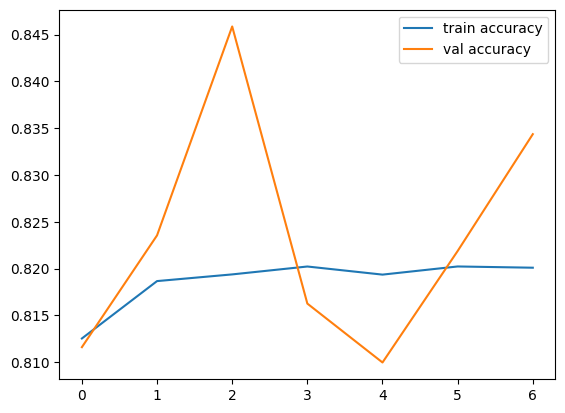

In [23]:
plt.plot(history.history["accuracy"], label = "train accuracy")
plt.plot(history.history["val_accuracy"], label = "val accuracy")
plt.legend()
plt.show()

In [25]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)

2026-02-23 00:27:18.027843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1853/1853 ━━━━━━━━━━━━━━━━━━━━ 56s 29ms/step


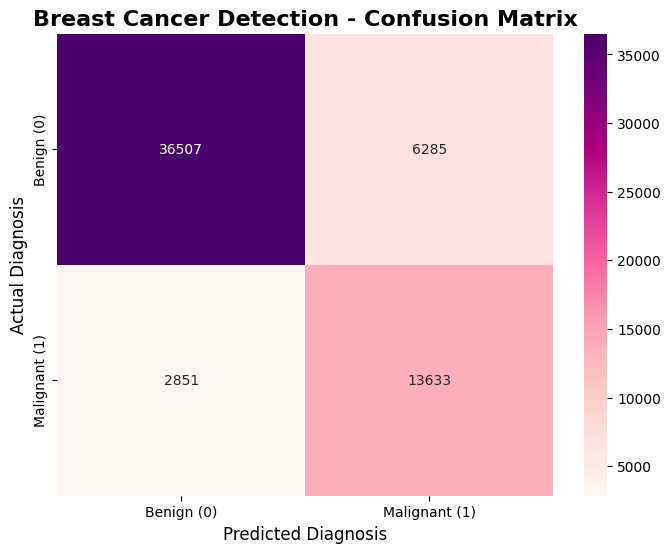


Detailed Performance Metrics:
              precision    recall  f1-score   support

      Benign       0.93      0.85      0.89     42792
   Malignant       0.68      0.83      0.75     16484

    accuracy                           0.85     59276
   macro avg       0.81      0.84      0.82     59276
weighted avg       0.86      0.85      0.85     59276



In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', 
            xticklabels=['Benign (0)', 'Malignant (1)'], 
            yticklabels=['Benign (0)', 'Malignant (1)'])

plt.title('Breast Cancer Detection - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('Actual Diagnosis', fontsize=12)
plt.xlabel('Predicted Diagnosis', fontsize=12)

plt.savefig('confusion_matrix_high_res.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDetailed Performance Metrics:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

In [29]:
model.save("breast_cancer_final_model.keras")
print("Model successfully saved!")

Model successfully saved!
